# Predicting Ground State Energies of Electron in a Box/Particle in a Box

*Important-Notebook 2 of 2

**NAME-VATSALYA SHARAN**

DEPT-PHY

ROLL_NO-18307

Importing all the required Libraries


In [25]:
import numpy as np
import math
import scipy.sparse as sp
import scipy.sparse.linalg as la
import matplotlib.pyplot as plt
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, MaxPooling2D, Conv2D, Flatten, Dropout
from keras.utils import to_categorical
from keras.layers import BatchNormalization


**Defining the function 'Solver_PIB' to solve and generate Particle in a Box Potential Energies**

This gives output in the form of a list of images and energy labels

In [26]:
def Solver_PIB(limit, L, number):
    x = np.linspace(-limit, limit, L)
    y = np.linspace(-limit, limit, L)
    #grid spacing
    dx = x[1]-x[0]
    dy = y[1]-y[0]
    mesh = np.meshgrid(x, y)
    block = sp.diags([-1,4,-1], [-1,0,1],(L,L)) #main tri-diagonal
    dia = sp.block_diag((block,)*L) #repeat it num times to create the main block
    sup = sp.diags([-1],[L],(L**2,L**2)) # super-diagonal fringe
    sub = sp.diags([-1],[-L],(L**2,L**2)) #sub-diagonal fringe
    T = (dia + sup + sub) / (2*dx*dy)\

    def solve(potential):
        V = sp.lil_matrix((L**2, L**2))
        V.setdiag(potential.flatten())
        H = T + V
        E= la.eigs(H, k=3, which='SM', return_eigenvectors=False)
        return E

    def V_INFW(a, b, lx, ly, ca, cb):
        V = np.zeros((L,L))
        for i in range(L):
            for j in range(L):
                if (0.5*(2*ca-lx)<a[i] and a[i]<0.5*(2*ca+lx))and(0.5*(2*cb-ly)<b[j]):
                  V[i][j]=0
                else:
                  V[i][j]=20
        return V
    image_list= []
    energy_list=[]

    np.random.seed(101)
    Ly=[]
    Lx=[]
    cx=[]
    cy=[]
    E = np.random.rand(number) * 0.4
    S = (np.random.rand(number) * 11) + 4
    for i in range(number):
        a = (2*E[i]/math.pi**2)-(1/S[i]**2)
        if a>0:
          Ly.append(1/math.sqrt(a))
          Lx.append(S[i])
          cx = (np.random.rand(len(Lx)) - 0.5) * 32
          cy = (np.random.rand(len(Lx)) - 0.5) * 32

    for k in range(len(Lx)):
        V_image_1 = V_INFW(x,y,Lx[k],Ly[k],cx[k],cy[k])
        E1 = solve(V_INFW(x,y,Lx[k],Ly[k],cx[k],cy[k]))
        image_list.append(V_image_1)
        energy_list.append(E1)
    return image_list, energy_list

**Generating the Dataset For Particle in a Box Potentials**

In [27]:
L2=64
data2, labels2 = Solver_PIB(limit=20, L=L2, number=12000)

**Dividing our data into testing and training sets**

In [28]:
p2 = int(0.8*np.shape(data2)[0])
q2 = int(0.2*np.shape(data2)[0])+1
train_data_2_1 = data2[:p2]
test_data_2_1 = data2[p2:]
train_labels_2_1 = labels2[:p2]
test_labels_2_1 = labels2[p2:]
np.shape(test_data_2_1)

(1911, 64, 64)

In [29]:
train_data_2_2=np.array(train_data_2_1)
test_data_2_2=np.array(test_data_2_1)
train_labels_2_2=np.array(train_labels_2_1)
test_labels_2_2=np.array(test_labels_2_1)

**Changing the Shape of our data to fit our model**

In [30]:
conv_training_data_2 = train_data_2_2.reshape(p2, L2,L2 , 1)
conv_test_data_2 = test_data_2_2.reshape(q2, L2, L2, 1)
np.shape(conv_training_data_2)

(7642, 64, 64, 1)

**Plotting to check our data**

The initial data looks like:

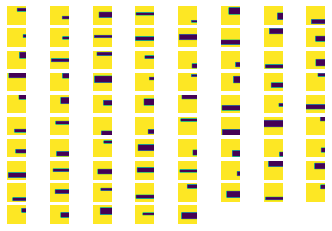

In [34]:
import matplotlib.pyplot as plt
for i in range(int(0.01*np.shape(conv_training_data_2)[0]+1)):
  ax = plt.subplot(10, 8, i+1)
  ax.axis('off')
  plt.imshow(train_data_2_2[i])


Data at the end of the list looks like:
Clearly the data has been evenly randomized

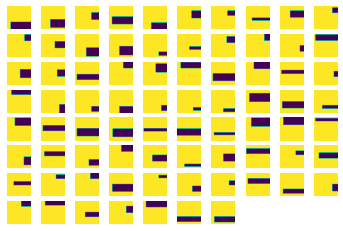

In [37]:
for i in range(int(0.99*np.shape(conv_training_data_2)[0]),np.shape(conv_training_data_2)[0]):
  ax = plt.subplot(8, 10, i-int(0.99*np.shape(conv_training_data_2)[0])+1)
  ax.axis('off')
  plt.imshow(train_data_2_2[i])

**Defining Function plot_training_history_2 which helps in evaluating our model**

In [38]:
def plot_training_history_2(history, model, eval_images=False):
  figure = plt.figure()
  plt.subplot(1, 2, 1)
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['training', 'validation'], loc='best')
  plt.tight_layout()
  plt.subplot(1, 2, 2)
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['training', 'validation'], loc='best')
  plt.tight_layout()
  figure.tight_layout()
  plt.show()
  if eval_images:
    loss, accuracy = model.evaluate(conv_test_data_2, test_labels_2_2, verbose=False)
  else:
    loss, accuracy = model.evaluate(test_data_2_2, test_labels_2_2, verbose=False)

  print(f'Test loss: {loss:.3}')
  print(f'Test accuracy: {accuracy:.3}')

**Bulinding our CNN model,compiling it and fitting the model with the data**

In [43]:
model2 = Sequential()
model2.add(Conv2D(128, kernel_size=(5, 5), strides=(2,2), activation='relu', padding='same'))
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(BatchNormalization())
model2.add(Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same',))
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(Flatten())
model2.add(Dense(256,activation='relu'))
model2.add(Dropout(rate=0.2))
model2.add(Dense(128,activation='relu'))
model2.add(Dense(3, activation='linear'))
model2.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

**Plotting using the plot history function to check for the accuracy of our model**

Epoch 1/24
192/192 [==============================] - 75s 391ms/step - loss: 1.5029 - accuracy: 0.4438 - val_loss: 0.0567 - val_accuracy: 0.6213
Epoch 2/24
192/192 [==============================] - 74s 388ms/step - loss: 0.0038 - accuracy: 0.7175 - val_loss: 0.0019 - val_accuracy: 0.9222
Epoch 3/24
192/192 [==============================] - 74s 386ms/step - loss: 0.0019 - accuracy: 0.8911 - val_loss: 0.0019 - val_accuracy: 0.9738
Epoch 4/24
192/192 [==============================] - 74s 385ms/step - loss: 0.0014 - accuracy: 0.9159 - val_loss: 8.9303e-04 - val_accuracy: 0.9457
Epoch 5/24
192/192 [==============================] - 74s 387ms/step - loss: 0.0011 - accuracy: 0.9324 - val_loss: 5.8906e-04 - val_accuracy: 0.9536
Epoch 6/24
192/192 [==============================] - 75s 390ms/step - loss: 9.2607e-04 - accuracy: 0.9398 - val_loss: 5.8923e-04 - val_accuracy: 0.9307
Epoch 7/24
192/192 [==============================] - 74s 387ms/step - loss: 7.5718e-04 - accuracy: 0.9542 - val_l

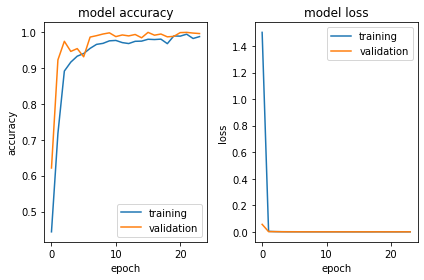

Test loss: 0.000407
Test accuracy: 0.995


In [44]:
history_2 = model2.fit(conv_training_data_2, train_labels_2_2, batch_size=32, epochs=24, verbose=True, validation_split=0.2)
model2.summary()
plot_training_history_2(history_2, model2, eval_images=True)

**Predicting the Energies for the test data using our Model**

/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_axes.py:6115: ComplexWarning: Casting complex values to real discards the imaginary part
  coords = np.column_stack((X, Y)).astype(float, copy=False)


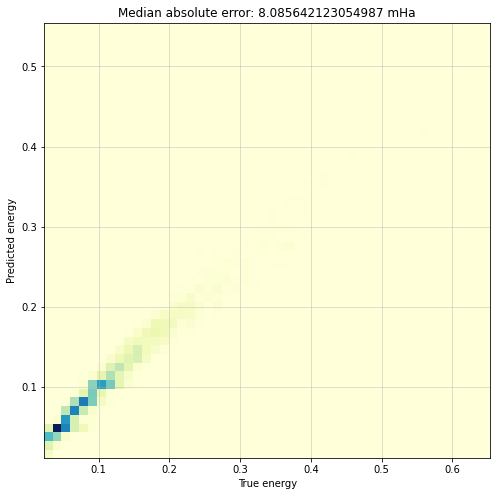

In [51]:
predictions_2 = model2.predict(conv_test_data_2)
prediction_2_1 = np.array(predictions_2).flatten()
fig, ax = plt.subplots(1,1, figsize=(8,8))
counts, xedges, yedges = np.histogram2d(test_labels_2_2.flatten(), prediction_2_1.flatten(),bins=50)
ax.pcolormesh(xedges, yedges, counts.T,cmap='YlGnBu')
ax.set_xlabel("True energy")
ax.set_ylabel("Predicted energy")
ax.grid(alpha=0.5)
ax.set_title("Median absolute error: {0} mHa".format(np.median(np.abs(prediction_2_1.flatten()-test_labels_2_2.flatten())*1000.)))
fig.show()